# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 15, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 15,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 1000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 1,#5000, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 1000,
                
        'interpretation_net_output_monomials': 15, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 500,
        'max_optimization_minutes': 120,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': True,
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 0,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 


import warnings

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.4.1'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/lib/cuda-10.1'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 816
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  12255


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_12255_drop0.25e1b256_custom/lnets_1000_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_0/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_1000_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_0/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed: 27.1min finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   29.8s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
782  1813382118                   0.000                   0.000   
20   1813382118                   0.000                   0.000   
54   1813382118                   0.000                   0.000   
585  1813382118                   0.000                   0.000   
297  1813382118                   0.000                   0.000   

     201000000000000-target  200100000000000-target  200010000000000-target  \
782                   0.000                   0.000                   0.000   
20                    0.000                   0.000                   0.000   
54                    0.000                   0.000                   0.000   
585                   0.000                   0.000                   0.000   
297                   0.000                   0.000                   0.000   

     200001000000000-target  200000100000000-target  200000010000000-target  \
782                   0.000                   0.000                   0.000   
20                    0.000                   0.000                   0.000   
54                    0.000                   0.000                   0.000   
585                   0.000                   0.000                   0.000   
297                   0.000                   0.000                   0.000   

     200000001000000-target  200000000100000-target  200000000010000-target  \
782                   0.505                   0.000                   0.000   
20                    0.000                   0.000                   0.000   
54                    0.000                   0.000                   0.000   
585                   0.000                   0.000                   0.000   
297                   0.000                   0.000                   0.000   

     200000000001000-target  200000000000100-target  200000000000010-target  \
782                   0.000                   0.000                   0.000   
20                    0.000                   0.000                   0.000   
54                    0.000                   0.000                   0.000   
585                   0.000                   0.000                   0.000   
297                   0.000                   0.000                   0.000   

     200000000000001-target  200000000000000-target  120000000000000-target  \
782                   0.000                   0.000                   0.000   
20                    0.000                   0.000                   0.000   
54                    0.000                  -0.186                   0.000   
585                   0.000                   0.000                   0.000   
297                   0.000                   0.000                   0.000   

     111000000000000-target  110100000000000-target  110010000000000-target  \
782                   0.000                   0.000                   0.000   
20                    0.000                   0.000                   0.000   
54                    0.000                   0.000                   0.000   
585                   0.000                   0.000                   0.000   
297                   0.000                   0.000                   0.000   

     110001000000000-target  110000100000000-target  110000010000000-target  \
782                   0.000                  -0.509                   0.000   
20                    0.000                   0.000                   0.000   
54                    0.000                   0.000                   0.000   
585                   0.000                   0.000                   0.000   
297                   0.000                   0.000                   0.000   

     110000001000000-target  110000000100000-target  110000000010000-target  \
782                   0.000                   0.000                   0.000   
20                    0.000                   0.000                   0.000   
54                    0.000                   

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  300000000000000-target  210000000000000-target  \
count       1000.000                1000.000                1000.000   
mean  1813382118.000                  -0.002                   0.001   
std            0.000                   0.052                   0.100   
min   1813382118.000                  -0.874                  -0.916   
25%   1813382118.000                   0.000                   0.000   
50%   1813382118.000                   0.000                   0.000   
75%   1813382118.000                   0.000                   0.000   
max   1813382118.000                   0.515                   0.927   

       201000000000000-target  200100000000000-target  200010000000000-target  \
count                1000.000                1000.000                1000.000   
mean                   -0.002                  -0.000                  -0.003   
std                     0.057                   0.075                   0.090   
min                    -0.810                  -0.870                  -0.993   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.934                   0.825                   0.861   

       200001000000000-target  200000100000000-target  200000010000000-target  \
count                1000.000                1000.000                1000.000   
mean                    0.003                  -0.003                   0.004   
std                     0.062                   0.078                   0.077   
min                    -0.955                  -0.920                  -0.936   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.855                   0.882                   0.819   

       200000001000000-target  200000000100000-target  200000000010000-target  \
count                1000.000                1000.000                1000.000   
mean                    0.005                  -0.004                   0.001   
std                     0.083                   0.061                   0.081   
min                    -0.810                  -0.982                  -0.981   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.976                   0.554                   0.986   

       200000000001000-target  200000000000100-target  200000000000010-target  \
count                1000.000                1000.000                1000.000   
mean                    0.001                  -0.002                   0.004   
std                     0.068                   0.075                   0.054   
min                    -0.836                  -0.940                  -0.256   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.927                   0.861                   0.886   

       200000000000001-target  200000000000000-target  120000000000000-target  \
count                1000.000                1000.000                1000.000   
mean                   -0.005                  -0.001                  -0.002   
std                     0.068                   0.089                   0.102   
min                    -0.985                  -0.989                  -0.886   
25%                     0.000             

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[9.37110222e-01, 8.83648749e-01, 4.96804745e-01, 5.59943857e-01,
        9.02179278e-01, 4.87186580e-01, 5.45606949e-01, 8.18958919e-01,
        7.97394988e-01, 1.77492832e-01, 1.21840222e-01, 2.28827901e-01,
        6.10980996e-01, 6.33430107e-01, 9.32754130e-01],
       [6.42024168e-01, 1.33060632e-01, 1.63918348e-01, 3.16005955e-01,
        9.43551189e-01, 9.12659915e-01, 2.67276061e-01, 1.30242839e-01,
        4.91613934e-01, 1.35404061e-01, 1.20969604e-01, 2.27636318e-01,
        5.50849677e-01, 3.19325276e-01, 1.55711709e-01],
       [1.73177204e-01, 1.90241318e-01, 3.41781360e-01, 1.81728361e-01,
        8.68941556e-01, 1.24941476e-01, 4.98519002e-01, 4.13184017e-01,
        9.03054368e-01, 5.12577715e-01, 4.18024028e-02, 7.77909028e-01,
        3.82614993e-01, 2.65397037e-01, 3.54750497e-01],
       [9.93583665e-01, 4.12574170e-01, 7.53920737e-01, 9.44973664e-01,
        6.45039049e-01, 3.47842965e-01, 1.30816928e-01, 7.19896565e-01,
        5.37825701e-01, 7.27190460e-0

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-0.68669373],
       [ 0.07379235],
       [-0.0459883 ],
       [ 0.08450431],
       [-1.02805424],
       [-0.22788578],
       [-0.20118038],
       [ 0.10401569],
       [ 0.15591361],
       [-0.09762228]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            _, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(45000, 3725)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(5000, 3725)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 3725)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
29046  1373158606                   0.000                   0.000   
32736  1373158606                   0.000                   0.000   
13476  1373158606                   0.000                   0.000   
24488  1373158606                   0.000                   0.000   
42814  1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
29046                   0.000                   0.000                   0.000   
32736                   0.000                   0.000                   0.000   
13476                   0.000                   0.000                   0.000   
24488                   0.000                   0.000                   0.000   
42814                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
29046                   0.000                   0.000                   0.000   
32736                   0.000                   0.000                   0.000   
13476                   0.000                   0.000                   0.000   
24488                   0.000                   0.000                   0.000   
42814                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
29046                   0.000                   0.000                   0.000   
32736                   0.000                   0.000                   0.000   
13476                   0.000                   0.000                   0.000   
24488                   0.000                   0.000                   0.000   
42814                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
29046                   0.000                   0.000                   0.000   
32736                   0.000                   0.000                   0.000   
13476                   0.000                   0.000                   0.000   
24488                   0.000                   0.000                   0.000   
42814                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
29046                   0.000                   0.000                   0.000   
32736                   0.000                   0.000                   0.000   
13476                   0.000                   0.000                   0.000   
24488                   0.000                   0.000                   0.000   
42814                   0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
29046                   0.000                   0.000                   0.000   
32736                   0.000                   0.000                   0.000   
13476                   0.000                   0.000                   0.000   
24488                   0.000                   0.000                   0.000   
42814                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
29046                   0.643                   0.000                   0.000   
32736                   0.000                   0.000                   0.000   
13476                   0.000                   0.000                   0.000   
24488                   0.000                   0.000                   0.000   
42814                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
29046                   0.000                   0.000                   0.624   
32736                   0.0

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
25957  1373158606                   0.000                   0.000   
19386  1373158606                   0.000                   0.000   
31501  1373158606                   0.000                   0.000   
35365  1373158606                   0.000                   0.000   
36753  1373158606                   0.000                  -0.262   

       201000000000000-target  200100000000000-target  200010000000000-target  \
25957                   0.000                   0.000                   0.000   
19386                   0.000                   0.000                   0.000   
31501                   0.000                   0.000                   0.000   
35365                   0.000                   0.000                   0.000   
36753                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
25957                   0.000                   0.000                   0.000   
19386                   0.000                   0.000                   0.000   
31501                   0.000                   0.000                   0.000   
35365                   0.000                   0.000                   0.000   
36753                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
25957                   0.000                   0.000                   0.000   
19386                   0.000                   0.000                   0.000   
31501                   0.000                   0.000                   0.000   
35365                   0.000                   0.000                   0.000   
36753                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
25957                   0.000                   0.000                   0.000   
19386                   0.000                   0.000                   0.000   
31501                   0.000                   0.000                   0.000   
35365                   0.000                   0.000                   0.000   
36753                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
25957                   0.000                   0.000                   0.000   
19386                   0.000                   0.000                   0.000   
31501                   0.000                   0.000                   0.000   
35365                   0.000                   0.000                   0.000   
36753                   0.000                   0.000                   0.484   

       111000000000000-target  110100000000000-target  110010000000000-target  \
25957                   0.000                   0.000                   0.000   
19386                   0.000                   0.000                   0.000   
31501                   0.000                   0.000                   0.000   
35365                   0.000                   0.000                   0.000   
36753                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
25957                   0.000                   0.000                   0.000   
19386                   0.000                   0.000                   0.000   
31501                   0.000                   0.000                   0.000   
35365                   0.000                   0.000                   0.000   
36753                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
25957                   0.000                   0.000                   0.000   
19386                   0.0

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
49   1813382118                   0.000                   0.000   
11   1813382118                   0.000                   0.000   
133  1813382118                   0.000                   0.000   
970  1813382118                   0.000                   0.000   
727  1813382118                   0.000                   0.000   

     201000000000000-target  200100000000000-target  200010000000000-target  \
49                    0.000                   0.000                   0.000   
11                    0.000                  -0.777                   0.000   
133                   0.000                   0.000                   0.000   
970                   0.000                   0.000                   0.000   
727                   0.000                   0.000                   0.000   

     200001000000000-target  200000100000000-target  200000010000000-target  \
49                    0.000                   0.000                   0.000   
11                    0.000                   0.000                   0.000   
133                   0.000                   0.000                   0.000   
970                   0.000                   0.000                   0.000   
727                   0.000                   0.000                   0.000   

     200000001000000-target  200000000100000-target  200000000010000-target  \
49                    0.000                   0.000                   0.082   
11                    0.000                   0.000                   0.000   
133                   0.000                   0.000                   0.000   
970                   0.000                   0.000                   0.000   
727                   0.000                   0.000                   0.000   

     200000000001000-target  200000000000100-target  200000000000010-target  \
49                    0.337                   0.000                   0.000   
11                    0.000                   0.000                   0.000   
133                   0.000                   0.000                   0.000   
970                   0.000                   0.000                   0.000   
727                   0.000                   0.000                   0.000   

     200000000000001-target  200000000000000-target  120000000000000-target  \
49                    0.000                   0.000                   0.000   
11                    0.000                   0.000                   0.000   
133                   0.000                   0.000                   0.000   
970                   0.000                   0.000                   0.000   
727                   0.000                   0.000                   0.000   

     111000000000000-target  110100000000000-target  110010000000000-target  \
49                    0.000                   0.000                   0.000   
11                    0.000                   0.000                   0.000   
133                   0.000                   0.000                   0.000   
970                   0.000                   0.000                   0.000   
727                   0.000                   0.000                   0.000   

     110001000000000-target  110000100000000-target  110000010000000-target  \
49                    0.000                   0.000                   0.000   
11                    0.000                   0.000                   0.000   
133                   0.000                   0.000                   0.000   
970                   0.000                   0.000                   0.000   
727                   0.000                   0.000                   0.000   

     110000001000000-target  110000000100000-target  110000000010000-target  \
49                    0.000                   0.000                   0.000   
11                    0.000                   0.000                   0.000   
133                   0.000                   

## Interpretation Network Training

In [23]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
176/176 [==============================] - 863s 5s/step - loss: 0.3519 - r2_inet_lambda_fv_loss: 0.3685 - val_loss: 0.3146 - val_r2_inet_lambda_fv_loss: 0.0814
Training Time: 0:14:29
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:01


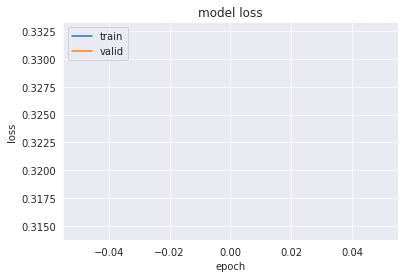

In [24]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [25]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [26]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [27]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [28]:
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [29]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
%load_ext autoreload

In [31]:
%autoreload 2
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 
    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed: 68.5min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed: 76.7min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed: 77.1min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed: 78.4min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed: 80.1min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed: 80.4min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed: 81.7min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed: 82.3min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed: 87.1min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed: 89.1min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed: 137.9min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 143.2min
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed: 145.5min
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed: 148.1min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapse

Symbolic Regression Optimization Time: 11:50:26
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 710.4min finished


In [32]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [33]:
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


False


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:23
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.6s finished


In [34]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_symbolic_regression_functions
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_target_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_symbolic_regression_functions
inet_polynomials_VS_symbolic_regression_functions
Score Calculation Time: 0:00:02
---------------------------------------------------------------------------------------------------------------------------
-----

In [35]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [36]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [37]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1276)]       0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          653824      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [38]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [39]:
scores_test_list[-1]

MAE  RMSE  MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN   NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN   NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN   NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN   NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN   NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.081 0.111 7.518   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.081 0.110 7.592   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN   NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.081 0.111 2.066   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.108 0.135 8.863   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN   NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.081 0.110 7.592   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN   NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN   NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.404   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.379   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.404   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.286   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.379   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...                  NaN   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   
lstsq_target_polynomials_VS_symbolic_regression...                  NaN   
inet_polynomials_VS_symbolic_regression_functions                   NaN   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.045    0.059    0.960   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.063    0.082    1.316   
lambda_preds_VS_lstsq_target_polynomials             0.045    0.059    0.960   
lambda_preds_VS_inet_polynomials                     0.435    0.532    2.917   
lambda_preds_VS_symbolic_regression_functions        0.211    0.269    3.114   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.063    0.082    1.639   
target_polynomials_VS_lstsq_target_polynomials       0.000    0.000    0.000   
target_polynomials_VS_inet_polynom

In [40]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.050 0.044 0.046 0.043   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.073 0.057 0.074 0.065   
lambda_preds_VS_lstsq_target_polynomials           0.050 0.044 0.046 0.043   
lambda_preds_VS_inet_polynomials                   0.343 0.240 0.312 0.217   
lambda_preds_VS_symbolic_regression_functions      0.216 0.178 0.262 0.189   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.072 0.057 0.069 0.060   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.344 0.243 0.308 0.220   
target_polynomials_VS_symbolic_regression_funct... 0.220 0.183 0.258 0.191   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.072 0.057 0.069 0.060   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.354 0.249 0.315 0.222   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.225 0.188 0.269 0.198   
lstsq_target_polynomials_VS_inet_polynomials       0.344 0.243 0.308 0.220   
lstsq_target_polynomials_VS_symbolic_regression... 0.220 0.183 0.258 0.191   
inet_polynomials_VS_symbolic_regression_functions  0.276 0.153 0.182 0.111   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.042 0.056 0.044 0.052   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.056 0.064 0.061 0.072   
lambda_preds_VS_lstsq_target_polynomials           0.042 0.056 0.044 0.052   
lambda_preds_VS_inet_polynomials                   0.540 0.519 0.639 1.166   
lambda_preds_VS_symbolic_regression_functions      0.176 0.159 0.255 0.258   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.057 0.068 0.059 0.069   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.542 0.523 0.640 1.160   
target_polynomials_VS_symbolic_regression_funct... 0.179 0.159 0.258 0.256   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.057 0.068 0.059 0.069   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.539 0.520 0.643 1.173   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.180 0.170 0.259 0.262   
lstsq_target_polynomials_VS_inet_polynomials       0.542 0.523 0.640 1.160   
lstsq_target_polynomials_VS_symbolic_regression... 0.179 0.159 0.258 0.256   
inet_polynomials_VS_symbolic_regression_functions  0.519 0.487 0.597 1.169   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.044 0.034 0.043 0.052   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.055 0.051 0.056 0.077   
lambda_preds_VS_lstsq_target_polynomials           0.044 0.034 0.043 0.052   
lambda_preds_VS_inet_polynomials                   0.186 0.324 0.495 0.613   
lambda_preds_VS_symbolic_regression_functions      0.183 0.231 0.195 0.203   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.059 0.050 0.060 0.074   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.196 0.330 0.497 0.620   
target_polynomials_VS_symbolic_regression_funct... 0.193 0.236 0.192 0.204   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.059 0.050 0.060 0.074   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.191 0.329 0.498 0.622   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.190 0.240 0.198 0.211   
lstsq_target_polynomials_VS_inet_polynomials       0.196 0.330 0.497 0.620   
lstsq_target_polynomials_VS_symbolic_regression... 0.193 0.236 0.192 0.204   
inet_polynomials_VS_symbolic_regression_functions  0.167 0.220 0.499 0.596   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.057 0.040 0.042 0.049   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.070 0.059 0.062 0.068   
lambda_preds_VS_lstsq_target_polynomials           0.057 0.040 0.042 0.0

In [41]:
distrib_dict_test_list[-1]['R2']

L-0     L-1     L-2  \
lambda_preds_VS_target_polynomials                   0.973   0.964   0.977   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.944   0.939   0.943   
lambda_preds_VS_lstsq_target_polynomials             0.973   0.964   0.977   
lambda_preds_VS_inet_polynomials                    -0.169   0.002   0.019   
lambda_preds_VS_symbolic_regression_functions        0.535   0.463   0.289   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.945   0.945   0.948   
target_polynomials_VS_lstsq_target_polynomials       1.000   1.000   1.000   
target_polynomials_VS_inet_polynomials              -0.160   0.005   0.016   
target_polynomials_VS_symbolic_regression_funct...   0.520   0.456   0.293   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.947   0.946   0.949   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   -0.162  -0.003   0.012   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   0.520   0.450   0.273   
lstsq_target_polynomials_VS_inet_polynomials        -0.160   0.005   0.016   
lstsq_target_polynomials_VS_symbolic_regression...   0.520   0.456   0.293   
inet_polynomials_VS_symbolic_regression_functions  -35.194 -16.154 -13.061   

                                                      L-3     L-4     L-5  \
lambda_preds_VS_target_polynomials                  0.956   0.986   0.947   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.908   0.976   0.935   
lambda_preds_VS_lstsq_target_polynomials            0.956   0.986   0.947   
lambda_preds_VS_inet_polynomials                    0.045  -0.977  -2.500   
lambda_preds_VS_symbolic_regression_functions       0.243   0.772   0.626   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.926   0.975   0.933   
target_polynomials_VS_lstsq_target_polynomials      1.000   1.000   1.000   
target_polynomials_VS_inet_polynomials              0.043  -0.939  -2.379   
target_polynomials_VS_symbolic_regression_funct...  0.250   0.759   0.619   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.927   0.974   0.934   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.039  -0.965  -2.252   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...  0.228   0.758   0.593   
lstsq_target_polynomials_VS_inet_polynomials        0.043  -0.939  -2.379   
lstsq_target_polynomials_VS_symbolic_regression...  0.250   0.759   0.619   
inet_polynomials_VS_symbolic_regression_functions  -2.751 -45.471 -36.910   

                                                        L-6      L-7    L-8  \
lambda_preds_VS_target_polynomials                    0.976    0.989  0.939   
lambda_preds_VS_lstsq_lambda_pred_polynomials         0.955    0.979  0.911   
lambda_preds_VS_lstsq_target_polynomials              0.976    0.989  0.939   
lambda_preds_VS_inet_polynomials                     -2.970   -3.200  0.023   
lambda_preds_VS_symbolic_regression_functions         0.232    0.736  0.041   
target_polynomials_VS_lstsq_lambda_pred_polynom...    0.958    0.981  0.909   
target_polynomials_VS_lstsq_target_polynomials        1.000    1.000  1.000   
target_polynomials_VS_inet_polynomials               -2.796   -3.102  0.023   
target_polynomials_VS_symbolic_regression_funct...    0.240    0.736  0.041   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...    0.958    0.981  0.903   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    -2.821   -3.104  0.040   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...    0.239    0.730  0.049   
lstsq_target_polynomials_VS_inet_polynomials         -2.796   -3.102  0.023   
lstsq_target_polynomials_VS_symbolic_regression...    0.240    0.736  0.041   
inet_polynomials_VS_symbolic_regression_functions  -195.889 -233.759 -3.913   

                                                       L-9    L-10     L-11  \
lambda_preds_VS_target_polynomials                   0.981   0.980    0.980   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.955   0.965    0.957   
lambda_preds_VS_lstsq_target_polynomials             0.981   0.980    0

In [42]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9076832423856293


-0.0012367233397044*a**3 + 0.0034413083038054*a**2*b - 0.0308378356762461*a**2*c + 0.127740229276436*a**2*d - 0.121749934144479*a**2*e + 0.0206430620843828*a**2*f - 0.0260298091863699*a**2*g + 0.0078853176452954*a**2*h + 0.0474109855214371*a**2*i - 0.200987253829527*a**2*j + 0.0704760377039829*a**2*k + 0.067015946274554*a**2*l - 0.01107515469206*a**2*m + 0.0050272980973706*a**2*n - 0.0893171126069843*a**2*o + 0.102433691755727*a**2 + 0.0355792858408284*a*b**2 - 0.133557458559065*a*b*c + 0.0153461571982225*a*b*d - 0.0129905044564665*a*b*e - 0.0577725575833722*a*b*f - 0.0866047865579505*a*b*g - 0.067553012042797*a*b*h - 0.111034932306694*a*b*i + 0.352467141832569*a*b*j - 0.0667373488657655*a*b*k + 0.150259555424323*a*b*l + 0.111708767673101*a*b*m + 0.108204828730387*a*b*n - 0.268762987450969*a*b*o + 0.0296773306448416*a*b + 0.0926735903680509*a*c**2 - 0.0253938268874515*a*c*d + 0.0314401783454244*a*c*e + 0.0199022198104875*a*c*f + 0.143038746597928*a*c*g + 0.0512764196314343*a*c*h + 0.06

In [43]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -0.9913829180996865 (100 Samples)
Mean (only positive): 0.03956585133277732 (8 Samples)


In [44]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9521484201163828 (100 Samples)
Mean (only positive): 0.9521484201163828 (100 Samples)


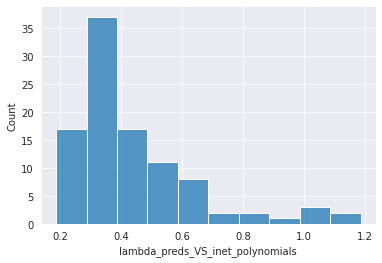

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

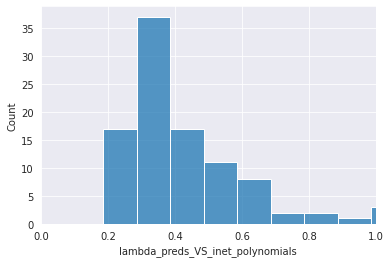

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


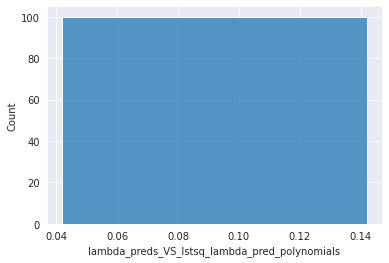

In [47]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

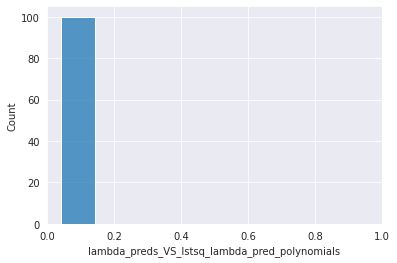

In [48]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


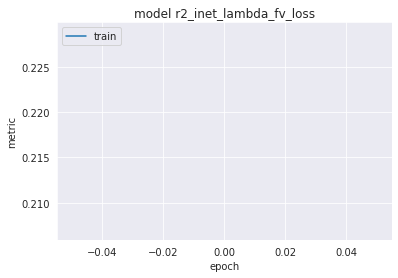

In [49]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


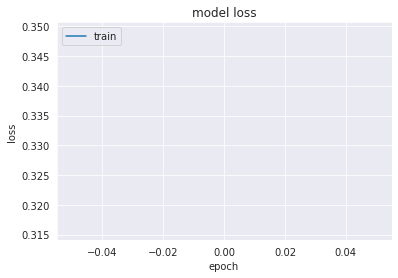

In [50]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [52]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [53]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [54]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.1641*a**3 - 0.1247*a**2*b - 0.1932*a**2*c + 0.0546*a**2*d - 0.0551*a**2*e + 0.1053*a**2*f - 0.1131*a**2*g - 0.066*a**2*h - 0.0442*a**2*i + 0.2569*a**2*j + 0.0829*a**2*k - 0.0544*a**2*l + 0.122*a**2*m - 0.1183*a**2*n - 0.0997*a**2*o - 0.0739*a**2 - 0.0648*a*b**2 + 0.0976*a*b*c + 0.038*a*b*d - 0.1999*a*b*e + 0.1207*a*b*f - 0.0239*a*b*g - 0.0114*a*b*h + 0.0133*a*b*i + 0.0363*a*b*j - 0.0196*a*b*k + 0.0983*a*b*l - 0.0674*a*b*m + 0.1101*a*b*n + 0.0292*a*b*o + 0.0664*a*b + 0.0627*a*c**2 - 0.0896*a*c*d + 0.2229*a*c*e + 0.032*a*c*f + 0.042*a*c*g + 0.1792*a*c*h - 0.0921*a*c*i + 0.1179*a*c*j - 0.0406*a*c*k - 0.0403*a*c*l + 0.0527*a*c*m + 0.0936*a*c*n - 0.0627*a*c*o - 0.1692*a*c - 0.0158*a*d**2 - 0.0355*a*d*e - 0.0011*a*d*f - 0.0406*a*d*g - 0.0005*a*d*h + 0.0811*a*d*i + 0.0721*a*d*j - 0.2694*a*d*k + 0.0011*a*d*l + 0.1165*a*d*m + 0.2082*a*d*n - 0.0287*a*d*o - 0.199*a*d + 0.1035*a*e**2 - 0.0418*a*e*f + 0.0014*a*e*g - 0.0976*a*e*h + 0.1315*a*e*i - 0.0516*a*e*j + 0.0799*a*e*k + 0.0208*a*e*l - 0.1017

[ 1.64077444e-01 -1.24735302e-01 -1.93210624e-01  5.46466563e-02
 -5.51065524e-02  1.05261625e-01 -1.13097137e-01 -6.59517183e-02
 -4.41799235e-02  2.56946827e-01  8.29079697e-02 -5.43526346e-02
  1.21975048e-01 -1.18289080e-01 -9.97487368e-02 -7.38585604e-02
 -6.47825777e-02  9.75770760e-02  3.80309896e-02 -1.99857292e-01
  1.20687251e-01 -2.39466139e-02 -1.14433662e-02  1.33483284e-02
  3.62982022e-02 -1.96128532e-02  9.82905139e-02 -6.73569126e-02
  1.10111025e-01  2.92473985e-02  6.63793467e-02  6.26560867e-02
 -8.96004586e-02  2.22858173e-01  3.20048844e-02  4.19517227e-02
  1.79219947e-01 -9.21346914e-02  1.17851197e-01 -4.05528724e-02
 -4.02885846e-02  5.26665500e-02  9.36194349e-02 -6.26827030e-02
 -1.69227176e-01 -1.57559480e-02 -3.54808547e-02 -1.06477573e-03
 -4.05999503e-02 -4.78660639e-04  8.10961472e-02  7.21282214e-02
 -2.69449934e-01  1.09183491e-03  1.16490268e-01  2.08209742e-01
 -2.87439948e-02 -1.99009158e-01  1.03534041e-01 -4.18280118e-02
  1.40023561e-03 -9.76189

-0.0945*a*c - 0.4056*a*d*h + 0.466*a*j*k - 0.5648*a*k + 0.6809*b*e*o + 0.4266*b*f*h + 0.7432*b*k**2 - 0.3057*c*j*k - 0.1581*d*h*j - 0.4009*e*f + 0.158*f*g*l - 0.9286*f*i*m - 0.6468*f*j**2 - 0.6082*g*h - 0.6076*g*n

[-1.61756006e-08 -1.50308032e-08 -1.76242826e-08 -6.57836816e-08
  7.51912299e-09 -2.22325358e-08  4.06218540e-08 -3.91424590e-08
  1.18907240e-08 -4.25911941e-08 -1.28268147e-08  3.96405563e-08
 -6.87546863e-08 -4.77309258e-08  1.42158604e-08  1.41095998e-07
 -9.79513814e-08  6.55902376e-08 -5.61816900e-08 -3.12646464e-08
  2.79799062e-08 -5.22605748e-08  2.79442128e-08  4.09608829e-09
  2.49575282e-08 -3.27936969e-10 -2.16951816e-08  6.67336053e-08
  7.80054213e-08  4.00173117e-08  3.22991902e-08 -2.95279085e-08
  5.24889301e-09 -2.90317546e-08 -1.06097506e-08  5.06602327e-08
 -1.15375682e-07 -5.81598189e-08 -4.60300671e-08 -1.43396067e-08
  3.09914220e-08 -4.50442263e-08  7.37223158e-08  7.26769411e-09
 -9.45151293e-02  6.43729439e-08  5.20066492e-08 -2.23998425e-08
 -1.86305998e-08 -4.05554551e-01 -2.43690940e-08 -5.80739352e-08
 -5.01216586e-09  3.57314199e-08  8.14671300e-09 -2.67330114e-08
 -2.78676117e-08  9.36981911e-08 -4.50967422e-08 -3.25140769e-08
 -1.33953761e-08 -1.98248

-0.0945*a*c - 0.4056*a*d*h + 0.466*a*j*k - 0.5648*a*k + 0.6809*b*e*o + 0.4266*b*f*h + 0.7432*b*k**2 - 0.3057*c*j*k - 0.1581*d*h*j - 0.4009*e*f + 0.158*f*g*l - 0.9286*f*i*m - 0.6468*f*j**2 - 0.6082*g*h - 0.6076*g*n

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.09451519  0.          0.          0.
  0.         -0.40555447  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

-0.00779999978840351*a*b*d + 0.0625*a*b*l + 0.067500002682209*b*g*o + 0.123199999332428*d*f*o - 0.00039999998989515*d*h*k + 0.0390999987721443*e**2*o - 0.0384000018239021*e*g*k - 0.0438000001013279*e*i*k - 0.171000003814697*f*h*i + 0.133900001645088*f*k - 0.0478999987244606*g*j*o + 0.0640999972820282*h*i**2 + 0.0315999984741211*h*l*n - 0.0502999983727932*i**2*n + 0.112199999392033*l*n

[ 0.03908952  0.11215898 -0.17097074 ...  0.00124099  0.0012549
  0.00116369]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


-X5*X8 - 1.12739571589628*X6*X9

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


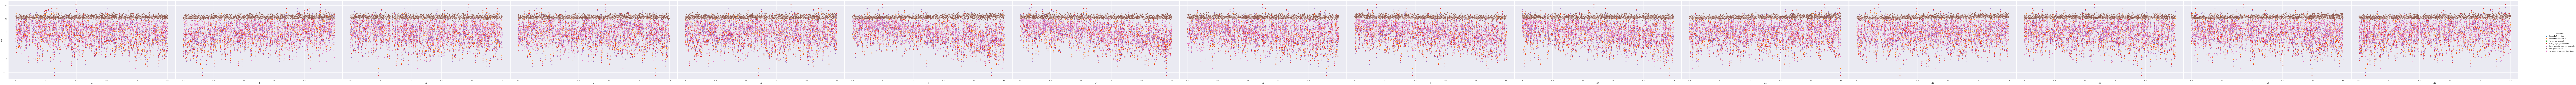

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [56]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

LinAlgError: Singular matrix

ValueError: 'bboxes' cannot be empty

<Figure size 0x0 with 256 Axes>

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()